In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.utils.visualize_util import plot


ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [32]:
import pydot
import graphviz

In [2]:
training_x = pickle.load( open( '../../Data/RentalListingData/sample_training_images.pkl', 'rb' ) )
training_y = pickle.load( open( '../../Data/RentalListingData/sample_training_outputs.pkl', 'rb' ) )
training_aux = pickle.load( open( '../../Data/RentalListingData/sample_training_aux.pkl', 'rb' ) )
training_features = pickle.load( open( '../../Data/RentalListingData/sample_training_features.pkl', 'rb' ) )

In [3]:
def plotImage(sample):
    plt.figure(figsize=(8,8))
    plt.imshow(sample)
    plt.show()

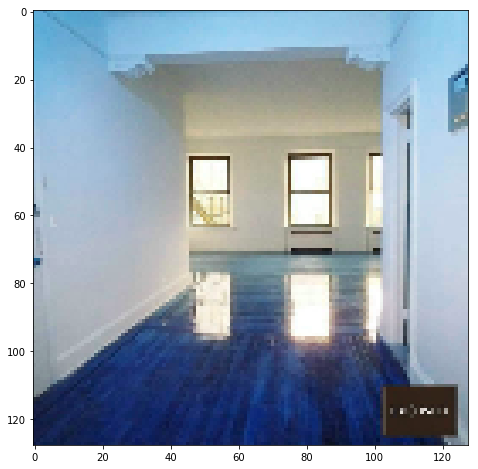

In [4]:
plotImage(training_x[32])

In [23]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


image_input = Input(shape=(128,128,3), name='image_input')

model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(image_input)
model = Convolution2D(32, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
model = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)

model = Flatten()(model)

model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)

model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)

image_out = model

aux_output = Dense(3, activation = 'softmax', name = 'aux_out')(image_out)


aux_input = Input(shape=(3,), name = 'aux_input')
aux_feature_input = Input(shape=(861,), name = 'aux_feature_input')

input_merge = merge([aux_input, aux_feature_input], mode = 'concat')

model = merge([image_out, input_merge], mode = 'concat')

model = Dense(60, activation='sigmoid')(model)
model = Dropout(0.5)(model)


model = Dense(3)(model)
predictions = Activation('softmax')(model)

model = Model(input = [image_input,aux_input,aux_feature_input], output = [predictions,aux_output])

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'], loss_weights = [1., 0.5])

In [40]:
nb_epoch = 30
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        #self.losses.append(logs.get('loss'))
        #self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')     

IndentationError: expected an indented block (<ipython-input-40-14ddc86bc3a3>, line 14)

In [7]:
history = LossHistory()

training_aux_clean = [training_aux[i] for i in range(len(training_aux)) if training_aux[i] != ['N/A','N/A','N/A']]
training_x_clean =   [training_x[i] for i in range(len(training_aux)) if training_aux[i] != ['N/A','N/A','N/A']]
training_y_clean = [training_y[i] for i in range(len(training_aux)) if training_aux[i] != ['N/A','N/A','N/A']]
training_features_clean = [training_features[i] for i in range(len(training_aux)) if training_aux[i] != ['N/A','N/A','N/A']]
mapping = [i for i in range(len(training_aux)) if training_aux[i] != ['N/A','N/A','N/A']]

In [9]:
training_x_clean = np.array(training_x_clean).astype(float)
training_y_clean = np.array(training_y_clean).astype(float)
training_aux_clean = np.array(training_aux_clean).astype(float)
training_features_clean = np.array(training_features_clean).astype(float)

In [21]:
np.shape(training_features_clean)

(3996, 861)

In [171]:
training_aux_clean[:,0]/100

array([ 30. ,  30. ,  30. , ...,  26.5,  26.5,  26.5])

In [25]:
model.fit([training_x_clean,training_aux_clean,training_features_clean], [training_y_clean,training_y_clean], batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.10, verbose=1, shuffle=True, callbacks=[history])

Epoch 00011: early stopping


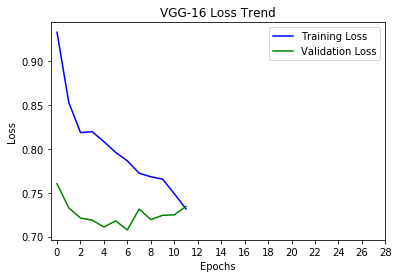

In [26]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [34]:
predictions = model.predict([training_x_clean,training_aux_clean,training_features_clean], verbose=0)

In [37]:
predictions[1][2]

array([ 0.29369682,  0.60971725,  0.09658595], dtype=float32)

In [38]:
training_y_clean[2]

array([ 0.,  0.,  1.])

I am 75.69% sure this property yields low interest
The price on this property is $3495.0 per month
I was wrong 
2957


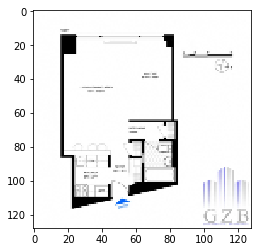

I am 72.34% sure this property yields low interest
The price on this property is $3400.0 per month
I was right!
559


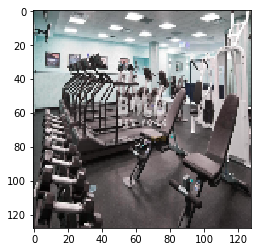

I am 53.35% sure this property yields low interest
The price on this property is $4025.0 per month
I was wrong 
2557


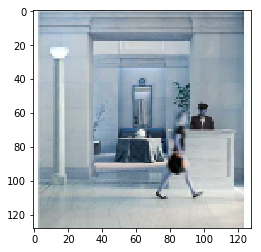

I am 68.77% sure this property yields low interest
The price on this property is $2400.0 per month
I was wrong 
666


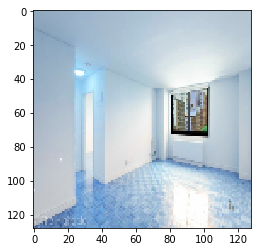

I am 75.20% sure this property yields low interest
The price on this property is $3600.0 per month
I was wrong 
2832


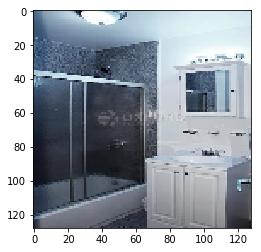

I am 64.90% sure this property yields medium interest
The price on this property is $2450.0 per month
I was wrong 
413


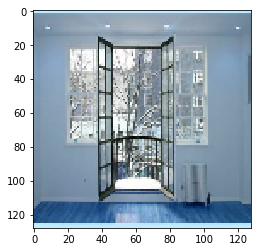

Im not really sure what interest this property yields
3759


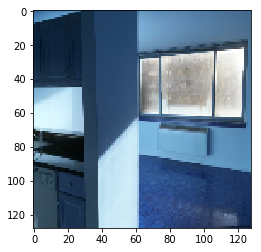

Im not really sure what interest this property yields
3929


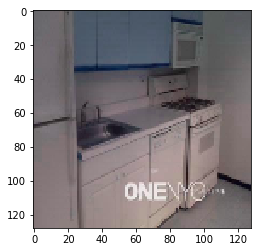

I am 62.21% sure this property yields low interest
The price on this property is $3785.0 per month
I was right!
2533


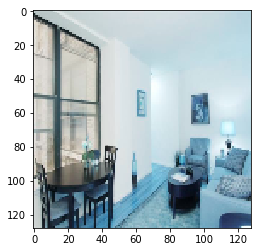

I am 60.33% sure this property yields medium interest
The price on this property is $2895.0 per month
I was wrong 
1078


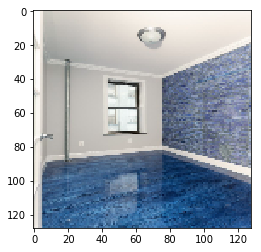

Im not really sure what interest this property yields
3984


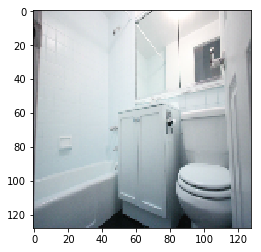

I am 70.17% sure this property yields low interest
The price on this property is $4095.0 per month
I was right!
798


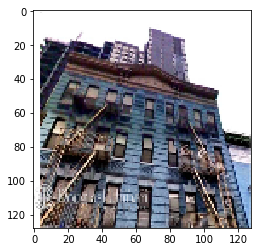

I am 58.36% sure this property yields low interest
The price on this property is $3855.0 per month
I was right!
1293


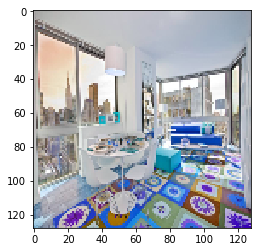

Im not really sure what interest this property yields
512


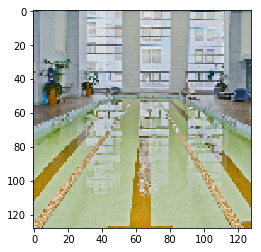

I am 57.55% sure this property yields low interest
The price on this property is $3045.0 per month
I was right!
3990


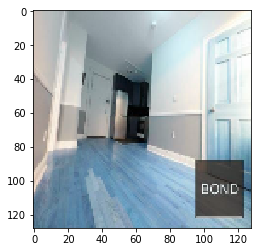

In [39]:
indx = 1

for i in np.random.randint(0,3996,15):
    if predictions[indx][i][0] >= 0.5: 
        print('I am {:.2%} sure this property yields low interest'.format(predictions[indx][i][0]))
        print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if training_y[i] == [1,0,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[indx][i][1] >= 0.5:
        print('I am {:.2%} sure this property yields medium interest'.format(predictions[indx][i][1]))
        print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if training_y[i] == [0,1,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[indx][i][2] >= 0.5:
        print('I am {:.2%} sure this propertry yields high interest'.format(predictions[indx][i][2]))
        print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if training_y[i] == [0,0,1]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    else:
        print('Im not really sure what interest this property yields')
        print(i)
        
    plt.imshow(training_x[mapping[i]])
    plt.show()
    
#     plt.imshow(training_x_clean[i])
#     plt.show()

In [211]:
print(predictions[1][2940])
print(training_y[2940])

[ 0.2974045   0.62871504  0.07388046]
[1, 0, 0]
